# <div style="text-align: center; background-color:#67001f; font-family:monospace; color: white; padding: 14px; line-height: 1;border-radius:20px">🕮 NLP Text Clustering & Web Scraping Project</div>

![Web Scraping](asset/img_webcraping.jpeg)

## <div style="text-align: left;background-color:#371de3; font-family:monospace; color: white; padding: 14px; line-height: 1; border-radius:10px"> Introduction 📚 </div>

Ce projet vise à scraper des données depuis le site [Books to Scrape](https://books.toscrape.com/), les transformer et les charger dans une base de données **SQLlite**. Par la suite, ces données sont utilisées pour entraîner un modèle de **clustering de texte** afin de classer les livres selon leur contenu textuel. Le projet est complété par un backend **FastAPI** pour exposer les résultats via une API REST.

## <div style="text-align: left;background-color:#371de3; font-family:monospace; color: white; padding: 14px; line-height: 1; border-radius:10px"> Architecture du Projet 🏗️ </div>

![architecture Data](asset/architecture_data.png)

## <div style="text-align: left;background-color:#371de3; font-family:monospace; color: white; padding: 14px; line-height: 1; border-radius:10px"> Objectifs 🎯 </div>

1. Scraper des données depuis **Books to Scrape**.
2. Construire et charger les données dans une base de données **Snowflake**.
3. Modéliser les données dans **SQLlite**.
4. Préparer les données pour le **clustering de texte**.
5. Entraîner un modèle de **clustering** avec **KMeans**.
6. Développer un backend **FastAPI** pour exposer les résultats.

##  <div style="text-align: left;background-color:#371de3; font-family:monospace; color: white; padding: 14px; line-height: 1; border-radius:10px"> Résultats 📊</div>

- **Database** : Les données sont collectées via le site web, notoyées, scruturées et stockées dans Snowflake.
- **Clustering** : Les livres sont regroupés en clusters basés sur des caractéristiques textuelles.
- **Exposition API** :
  - Endpoint : `/clusters` → Retourne les clusters de livres.
  - Endpoint : `/predict` → Prédit le cluster d’un livre donné.


# <div style="text-align: center; background-color:#b2182b; font-family:newtimeroman; color: white; padding: 14px; line-height: 1;border-radius:20px">0. Import Necessary Libraries</div>

In [1]:
# dataframe
import pandas as pd
import numpy as np
from uuid import uuid4

# data visualization
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.figure_factory as ff
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import plot
from wordcloud import WordCloud
from PIL import Image

# request, websraping
import requests
from bs4 import BeautifulSoup, NavigableString, Tag
import re

# tensorflow, for NN
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, GlobalMaxPooling1D, Dropout


# NLTK, NLP Libraries
import nltk
from nltk.util import ngrams
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
nltk.download('omw-1.4')

# sklearn, for preprocessing & scoring
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\vital.guinguinni\AppData\Roaming\nltk_data...


# <div style="text-align: center; background-color:#b2182b; font-family:newtimeroman; color: white; padding: 14px; line-height: 1;border-radius:20px">1. Web Scraping</div>

In [ ]:
# URL page web
URL = 'https://books.toscrape.com/'
response = requests.get(URL)

# Content page
page_contents = response.text

# Loading the content into a file
with open(r'data\Bookswebpage.html','w') as file:
    file.write(page_contents)

In [3]:
## Parse and Extracte informations
document = BeautifulSoup(page_contents,'html.parser')

## print(document.prettify()[1:])

In [4]:
## Finding Book Categories URL
categories_urls = [URL + x.get('href') for x in document.find_all("a", href=re.compile("catalogue/category/books"))]
categories_urls = categories_urls[1:] # we remove the first one because it corresponds to all the books

print(str(len(categories_urls)) + " fetched categories URLs")
print("Some examples:")
categories_urls[:3]

50 fetched categories URLs
Some examples:


['https://books.toscrape.com/catalogue/category/books/travel_2/index.html',
 'https://books.toscrape.com/catalogue/category/books/mystery_3/index.html',
 'https://books.toscrape.com/catalogue/category/books/historical-fiction_4/index.html']

In [5]:
# Pipeline to get Books URL

## Define a function to request and parse HTML webpage
def getAndParseURL(url):
    result = requests.get(url)
    soup = BeautifulSoup(result.text, 'html.parser')
    return(soup)

In [6]:
## Defining a function to retrieve book links from each categorie
def getBooksURLs(url):
    soup = getAndParseURL(url)
    # remove the index.html part of the base url before returning the results
    return(["/".join(url.split("/")[:-1]) + "/" + x.div.a.get('href') for x in soup.findAll("article", class_ = "product_pod")])


In [7]:
# In each book category there might be fiew pages containing the books
# in this code bellow I will iterate on each page in the book catergories (if there is more then one page)

pages_urls_categories = []

for pages_categorie in categories_urls:
    
    soup = getAndParseURL(pages_categorie)
    if  not soup.findAll("a", href=re.compile("page")) == [] : # this line is to check is in this book categorie there is fiew pages of books
        pages_urls_categories.append(pages_categorie)
        while not soup.findAll('li' , class_ = 'next') == [] : # this line is to check if there is still a next page. Indeed while the botton 'next' excist, this indicates that there is still another page of books
    
            # get the new complete url by adding the fetched URL to the base URL (and removing the index.html part of the base URL)
            new_url = "/".join(pages_categorie.split('/')[:-1]) + "/" + soup.findAll("a", href=re.compile("page"))[-1].get("href")
    
            # add the URL to the list
            pages_urls_categories.append(new_url)
        
            # parse the next page
            soup = getAndParseURL(new_url)
    else: # if the book category is only one page then I'll add it's url to the list
        pages_urls_categories.append(pages_categorie)
        
pages_urls_categories

['https://books.toscrape.com/catalogue/category/books/travel_2/index.html',
 'https://books.toscrape.com/catalogue/category/books/mystery_3/index.html',
 'https://books.toscrape.com/catalogue/category/books/mystery_3/page-2.html',
 'https://books.toscrape.com/catalogue/category/books/historical-fiction_4/index.html',
 'https://books.toscrape.com/catalogue/category/books/historical-fiction_4/page-2.html',
 'https://books.toscrape.com/catalogue/category/books/sequential-art_5/index.html',
 'https://books.toscrape.com/catalogue/category/books/sequential-art_5/page-2.html',
 'https://books.toscrape.com/catalogue/category/books/sequential-art_5/page-3.html',
 'https://books.toscrape.com/catalogue/category/books/sequential-art_5/page-4.html',
 'https://books.toscrape.com/catalogue/category/books/classics_6/index.html',
 'https://books.toscrape.com/catalogue/category/books/philosophy_7/index.html',
 'https://books.toscrape.com/catalogue/category/books/romance_8/index.html',
 'https://books.to

In [8]:
# Find book URL
booksURLs = []
for page in pages_urls_categories:
    booksURLs.extend(getBooksURLs(page))
    
print(str(len(booksURLs)) + " fetched URLs")
print("Some examples:")
booksURLs[:5]

1000 fetched URLs
Some examples:


['https://books.toscrape.com/catalogue/category/books/travel_2/../../../its-only-the-himalayas_981/index.html',
 'https://books.toscrape.com/catalogue/category/books/travel_2/../../../full-moon-over-noahs-ark-an-odyssey-to-mount-ararat-and-beyond_811/index.html',
 'https://books.toscrape.com/catalogue/category/books/travel_2/../../../see-america-a-celebration-of-our-national-parks-treasured-sites_732/index.html',
 'https://books.toscrape.com/catalogue/category/books/travel_2/../../../vagabonding-an-uncommon-guide-to-the-art-of-long-term-world-travel_552/index.html',
 'https://books.toscrape.com/catalogue/category/books/travel_2/../../../under-the-tuscan-sun_504/index.html']

In [9]:
# Get book data

names = []
prices = []
nb_in_stock = []
img_urls = []
categories = []
ratings = []
description = []

# scrape data for every book URL: this may take some time
for url in booksURLs:
    soup = getAndParseURL(url)
    # product name
    names.append(soup.find("div", class_ = re.compile("product_main")).h1.text)
    
    # product price
    prices.append(soup.find("p", class_ = "price_color").text[2:]) # get rid of the pound sign
    
    # number of available products
    nb_in_stock.append(re.sub("[^0-9]", "", soup.find("p", class_ = "instock availability").text)) # get rid of non numerical characters
    
    # image url
    img_urls.append(url.replace("index.html", "") + soup.find("img").get("src"))
    
    # product category
    categories.append(soup.find("a", href = re.compile("../category/books/")).get("href").split("/")[3])
    
    # ratings
    ratings.append(soup.find("p", class_ = re.compile("star-rating")).get("class")[1])
    
    # description
    # After observing the html of book categorie webpage, it is shown that the book description is after the 4th <p>
    text = []
    for i in soup.find_all('p'):
        text.append(i)
    description.append(text[3])
    

In [10]:
## Transform the data into dataframe in pandas
Book_Data = pd.DataFrame({'name': names, 'price': prices, 'nb_in_stock': nb_in_stock, "url_img": img_urls, "product_category": categories, "rating": ratings,"description" : description})
Book_Data.head(5)

,name,price,nb_in_stock,url_img,product_category,rating,description
0,It's Only the Himalayas,45.17,19,https://books.toscrape.com/catalogue/category/...,travel_2,Two,"[âWherever you go, whatever you do, just . ...."
1,Full Moon over Noahâs Ark: An Odyssey to Mou...,49.43,15,https://books.toscrape.com/catalogue/category/...,travel_2,Four,[Acclaimed travel writer Rick Antonson sets hi...
2,See America: A Celebration of Our National Par...,48.87,14,https://books.toscrape.com/catalogue/category/...,travel_2,Three,[To coincide with the 2016 centennial annivers...
3,Vagabonding: An Uncommon Guide to the Art of L...,36.94,8,https://books.toscrape.com/catalogue/category/...,travel_2,Two,[With a new foreword by Tim Ferriss â¢Thereâ...
4,Under the Tuscan Sun,37.33,7,https://books.toscrape.com/catalogue/category/...,travel_2,Three,[A CLASSIC FROM THE BESTSELLING AUTHOR OF UNDE...


In [11]:
## Data Cleaning
dataTypeSeries = Book_Data.dtypes
print('Data type of each column of Dataframe :')
print(dataTypeSeries)

Data type of each column of Dataframe :
name                object
price               object
nb_in_stock         object
url_img             object
product_category    object
rating              object
description         object
dtype: object


In [12]:
## Transform rating str to float
Book_Data["rating"] = Book_Data["rating"].replace({"One" : 1 , "Two" : 2, "Three" : 3 , "Four":4, "Five" : 5})

In [13]:
## Converting the book data to the right data type
Book_Data['nb_in_stock']=Book_Data['nb_in_stock'].astype(str).astype(int)
Book_Data[['price','rating']]=Book_Data[['price','rating']].astype(str).astype(float)
Book_Data[['name',"url_img","product_category","description"]]=Book_Data[['name',"url_img","product_category","description"]].astype('string')

In [14]:
dataTypeSeries_After = Book_Data.dtypes
print('Data type of each column of Dataframe :')
print(dataTypeSeries_After)

Data type of each column of Dataframe :
name                string[python]
price                      float64
nb_in_stock                  int32
url_img             string[python]
product_category    string[python]
rating                     float64
description         string[python]
dtype: object


In [15]:
#Removing the last characters from the book category after "_"
Book_Data["product_category"]=Book_Data["product_category"].str.split("_",n= 1, expand = True)[0]

#Removing the first 3 characters from book description and the last 13 ( ...more</p>')
Book_Data["description"]  = Book_Data["description"].str[3:-13]

Book_Data.head()

,name,price,nb_in_stock,url_img,product_category,rating,description
0,It's Only the Himalayas,45.17,19,https://books.toscrape.com/catalogue/category/...,travel,2.0,"âWherever you go, whatever you do, just . . ..."
1,Full Moon over Noahâs Ark: An Odyssey to Mou...,49.43,15,https://books.toscrape.com/catalogue/category/...,travel,4.0,Acclaimed travel writer Rick Antonson sets his...
2,See America: A Celebration of Our National Par...,48.87,14,https://books.toscrape.com/catalogue/category/...,travel,3.0,To coincide with the 2016 centennial anniversa...
3,Vagabonding: An Uncommon Guide to the Art of L...,36.94,8,https://books.toscrape.com/catalogue/category/...,travel,2.0,With a new foreword by Tim Ferriss â¢Thereâ...
4,Under the Tuscan Sun,37.33,7,https://books.toscrape.com/catalogue/category/...,travel,3.0,A CLASSIC FROM THE BESTSELLING AUTHOR OF UNDER...


In [16]:
# Créer une colonne pour associer un code unique à chaque URL
if 'unique_id' not in Book_Data.columns:
    unique_codes = {url: idx + 1 for idx, url in enumerate(Book_Data['url_img'].unique())}
    Book_Data['unique_id'] = Book_Data['url_img'].map(unique_codes)


In [ ]:
# Créer un dossier pour stocker les images

dossier_images = "data/books_images_metadata"
os.makedirs(dossier_images, exist_ok=True)

images_metadata = []
# Parcourir les données et télécharger les images
for index, row in Book_Data.iterrows():
    url_img = row['url_img']  # Colonne contenant l'URL de l'image
    category = row['product_category']  # Colonne contenant la catégorie
    unique_id = row['unique_id']  # Utiliser l'ID unique associé à l'URL

    # Créer le nom de fichier
    nom_fichier = f"{category}-{unique_id}.jpg"
    chemin_complet = os.path.join(dossier_images, nom_fichier)

    # Ajouter les métadonnées
    images_metadata.append({
        "url": url,
        "category": category,
        "unique_id": unique_id,
        "file_path": chemin_complet
    })

    try:
        # Télécharger l'image
        response = requests.get(url_img, stream=True)
        if response.status_code == 200:
            with open(chemin_complet, 'wb') as f:
                for chunk in response.iter_content(1024):
                    f.write(chunk)
        else:
            print(f"Erreur lors du téléchargement de l'image à l'index {index}: {response.status_code}")
    except Exception as e:
        print(f"Erreur pour l'image à l'index {index}: {e}")



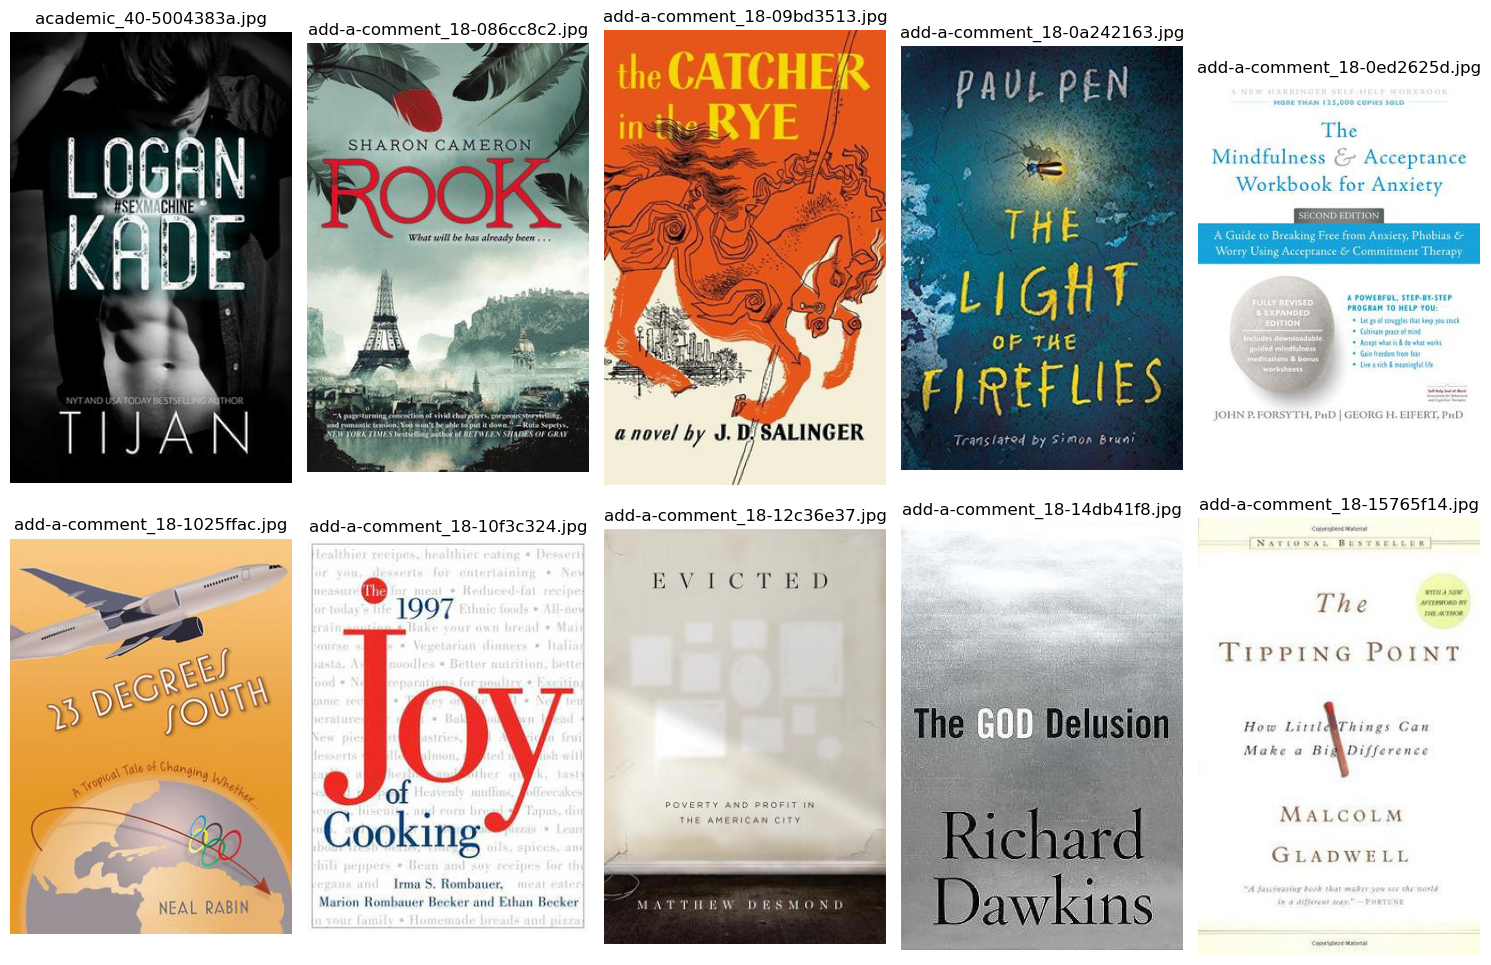

In [ ]:
# Afficher les 10 premières images téléchargées
image_files = os.listdir(dossier_images)[:10]
plt.figure(figsize=(15, 10))
for i, image_file in enumerate(image_files):
    image_path = os.path.join(dossier_images, image_file)
    img = Image.open(image_path)
    plt.subplot(2, 5, i + 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(image_file)
plt.tight_layout()
plt.show()


In [ ]:
# Sauvegarder la dataframe mise à jour avec les IDs uniques
Book_Data.to_csv(r'data\books_dataframe_cleaned.csv', index=False)

# Enregistrer les métadonnées dans un fichier JSON
import json
metadata_file = "books_images_metadata.json"
with open(metadata_file, "w") as json_file:
    json.dump(images_metadata, json_file, indent=4)

print("Téléchargement terminé !")

Téléchargement terminé !


## <div style="text-align: center; background-color:#ECF0F1 ; font-family:newtimeroman; color: black; padding: 40px; line-height: 1;border-radius:40px"> 🙇Thank You For Watching ! <br><br>Please upvote if you like this notebook !</div>